# COURSE: A deep understanding of deep learning
## SECTION: Measuring model performance
### LECTURE: APRF example 2: MNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202108

In [184]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# NEW!
import sklearn.metrics as skm
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Import Data Set

In [185]:
transform = T.Compose([ T.ToTensor(),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True,transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True,transform=transform)

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=len(testset))

In [186]:
trainset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

# Create the DL model

In [187]:
# create a class for the model
def createTheFMNISTNet():

  class fmnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      #self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      #x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = fmnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [188]:
X,y = next(iter(test_loader))

# Cheking the size
print('Data shapes (train/test):')
print( X.data.shape )

# the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([10000, 1, 28, 28])

Data value range:
(tensor(-1.), tensor(1.))


In [189]:
torch.squeeze(X).reshape(10000,28*28)

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

# Create a function that trains the model

In [190]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = createTheFMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
      
      # forward pass and loss
      yHat = net(torch.squeeze(X).reshape(32,28*28))
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(torch.squeeze(X).reshape(10000,28*28))
      #torch.squeeze(X).reshape(32,28*28)
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,yHat


# Run the model and show the results!

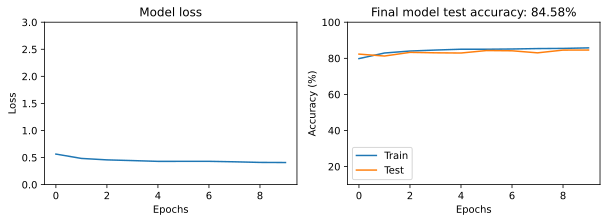

In [191]:
# build and train the model
trainAcc,testAcc,losses,net,yHat = function2trainTheModel()


# visualization starts here
fig,ax = plt.subplots(1,2,figsize=(10,3))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Compute the performance measures on the train and test data

In [192]:
test_predictions = torch.argmax(yHat,axis=1)
test_predictions

tensor([9, 2, 1,  ..., 8, 1, 5])

In [193]:
# Brief aside on computing precision et al. in multiclass data:
# There are now 10 classes, so there are 10 precision values.
## option 2: compute average precision, weighted by N
skm.precision_score(testset.targets,test_predictions,average='weighted')

0.8482116817068797

In [194]:
# initialize vectors
test_metrics  = [0,0,0,0]
# test
test_metrics[0] = skm.accuracy_score (testset.targets,test_predictions)
test_metrics[1] = skm.precision_score(testset.targets,test_predictions,average='weighted')
test_metrics[2] = skm.recall_score   (testset.targets,test_predictions,average='weighted')
test_metrics[3] = skm.f1_score       (testset.targets,test_predictions,average='weighted')

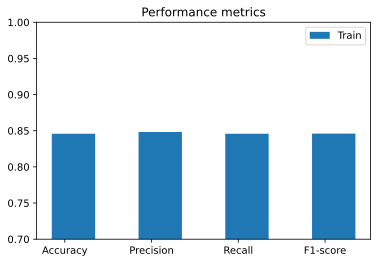

In [199]:
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.7,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

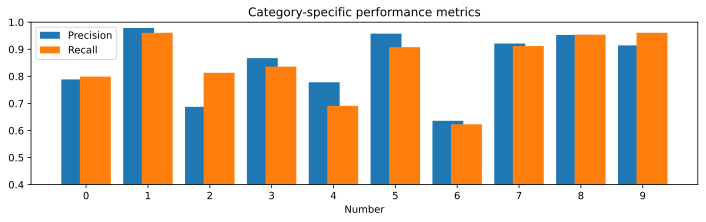

In [196]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(testset.targets,test_predictions,average=None)
recall    = skm.recall_score   (testset.targets,test_predictions,average=None)


fig = plt.figure(figsize=(12,3))
plt.bar(np.arange(10)-.15,precision,.5)
plt.bar(np.arange(10)+.15,recall,.5)
plt.xticks(range(10),range(10))
plt.ylim([.4,1])
plt.xlabel('Number')
plt.legend(['Precision','Recall'])
plt.title('Category-specific performance metrics')
plt.show()

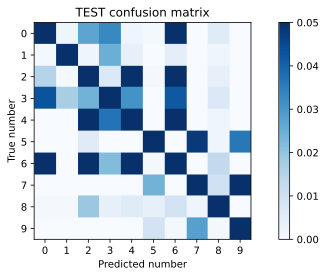

In [201]:
# Confusion matrices
testConf  = skm.confusion_matrix(testset.targets,test_predictions,normalize='true')

fig,ax = plt.subplots(1,1,figsize=(10,4))

# confmat during TEST
a = ax.imshow(testConf,cmap='Blues',vmax=.05)
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_title('TEST confusion matrix')
ax.set_xlabel('Predicted number')
ax.set_ylabel('True number')

fig.colorbar(a)
plt.show()

# Additional explorations

In [198]:
# 1) The Adam optimizer is pretty amazing, isn't it? Change the code to get the overall test accuracy between 50% and 80%.
#    You can consider changing the optimizer, learning rate, and number of epochs. Then show the performance metrics.
#    Are there systematic difficulties with some numbers, or simply a general decline in performance overall?
# 
# 2) Are the y-axis and color-limits still appropriate? Modify the visualization code so that the graphs are adaptive
#    to the numerical values of the performance metrics and confusion matrices.
#    